In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import pandas as pd

In [2]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

pdo['time'] = sst['time']

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [3]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()

In [4]:
nino_34_calc = np.zeros((1860))
for i in range(1860):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

In [6]:
# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':sst['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [7]:
pdo_1940_2024 = pdo.sel(time=pdo.time.dt.year.isin(np.arange(1940, 2025, 1)))
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

In [12]:
# Need to calculate when El Nino/La Nina Occurs in a given year
nino_34_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
        nino_34_1940_2024_mam_ann[i] = 1

    elif nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
        nino_34_1940_2024_mam_ann[i] = -1

    else:
        continue

In [13]:
nino_34_1940_2024_mam_ann

array([ 1.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
        0.,  0., -1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0., -1.,  0.,  1., -1.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1., -1., -1.,  0.,  1.,  0., -1.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  1., -1., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1., -1.,  1., -1.,  0.,  0.,  0.,  1.,  1.,  0.,
       -1.,  1.,  0., -1., -1.,  0.,  1.])

In [20]:
years[nino_34_1940_2024_mam_ann == -1]

array([1943, 1950, 1951, 1955, 1956, 1971, 1974, 1976, 1984, 1985, 1989,
       1999, 2000, 2008, 2009, 2011, 2018, 2021, 2022])

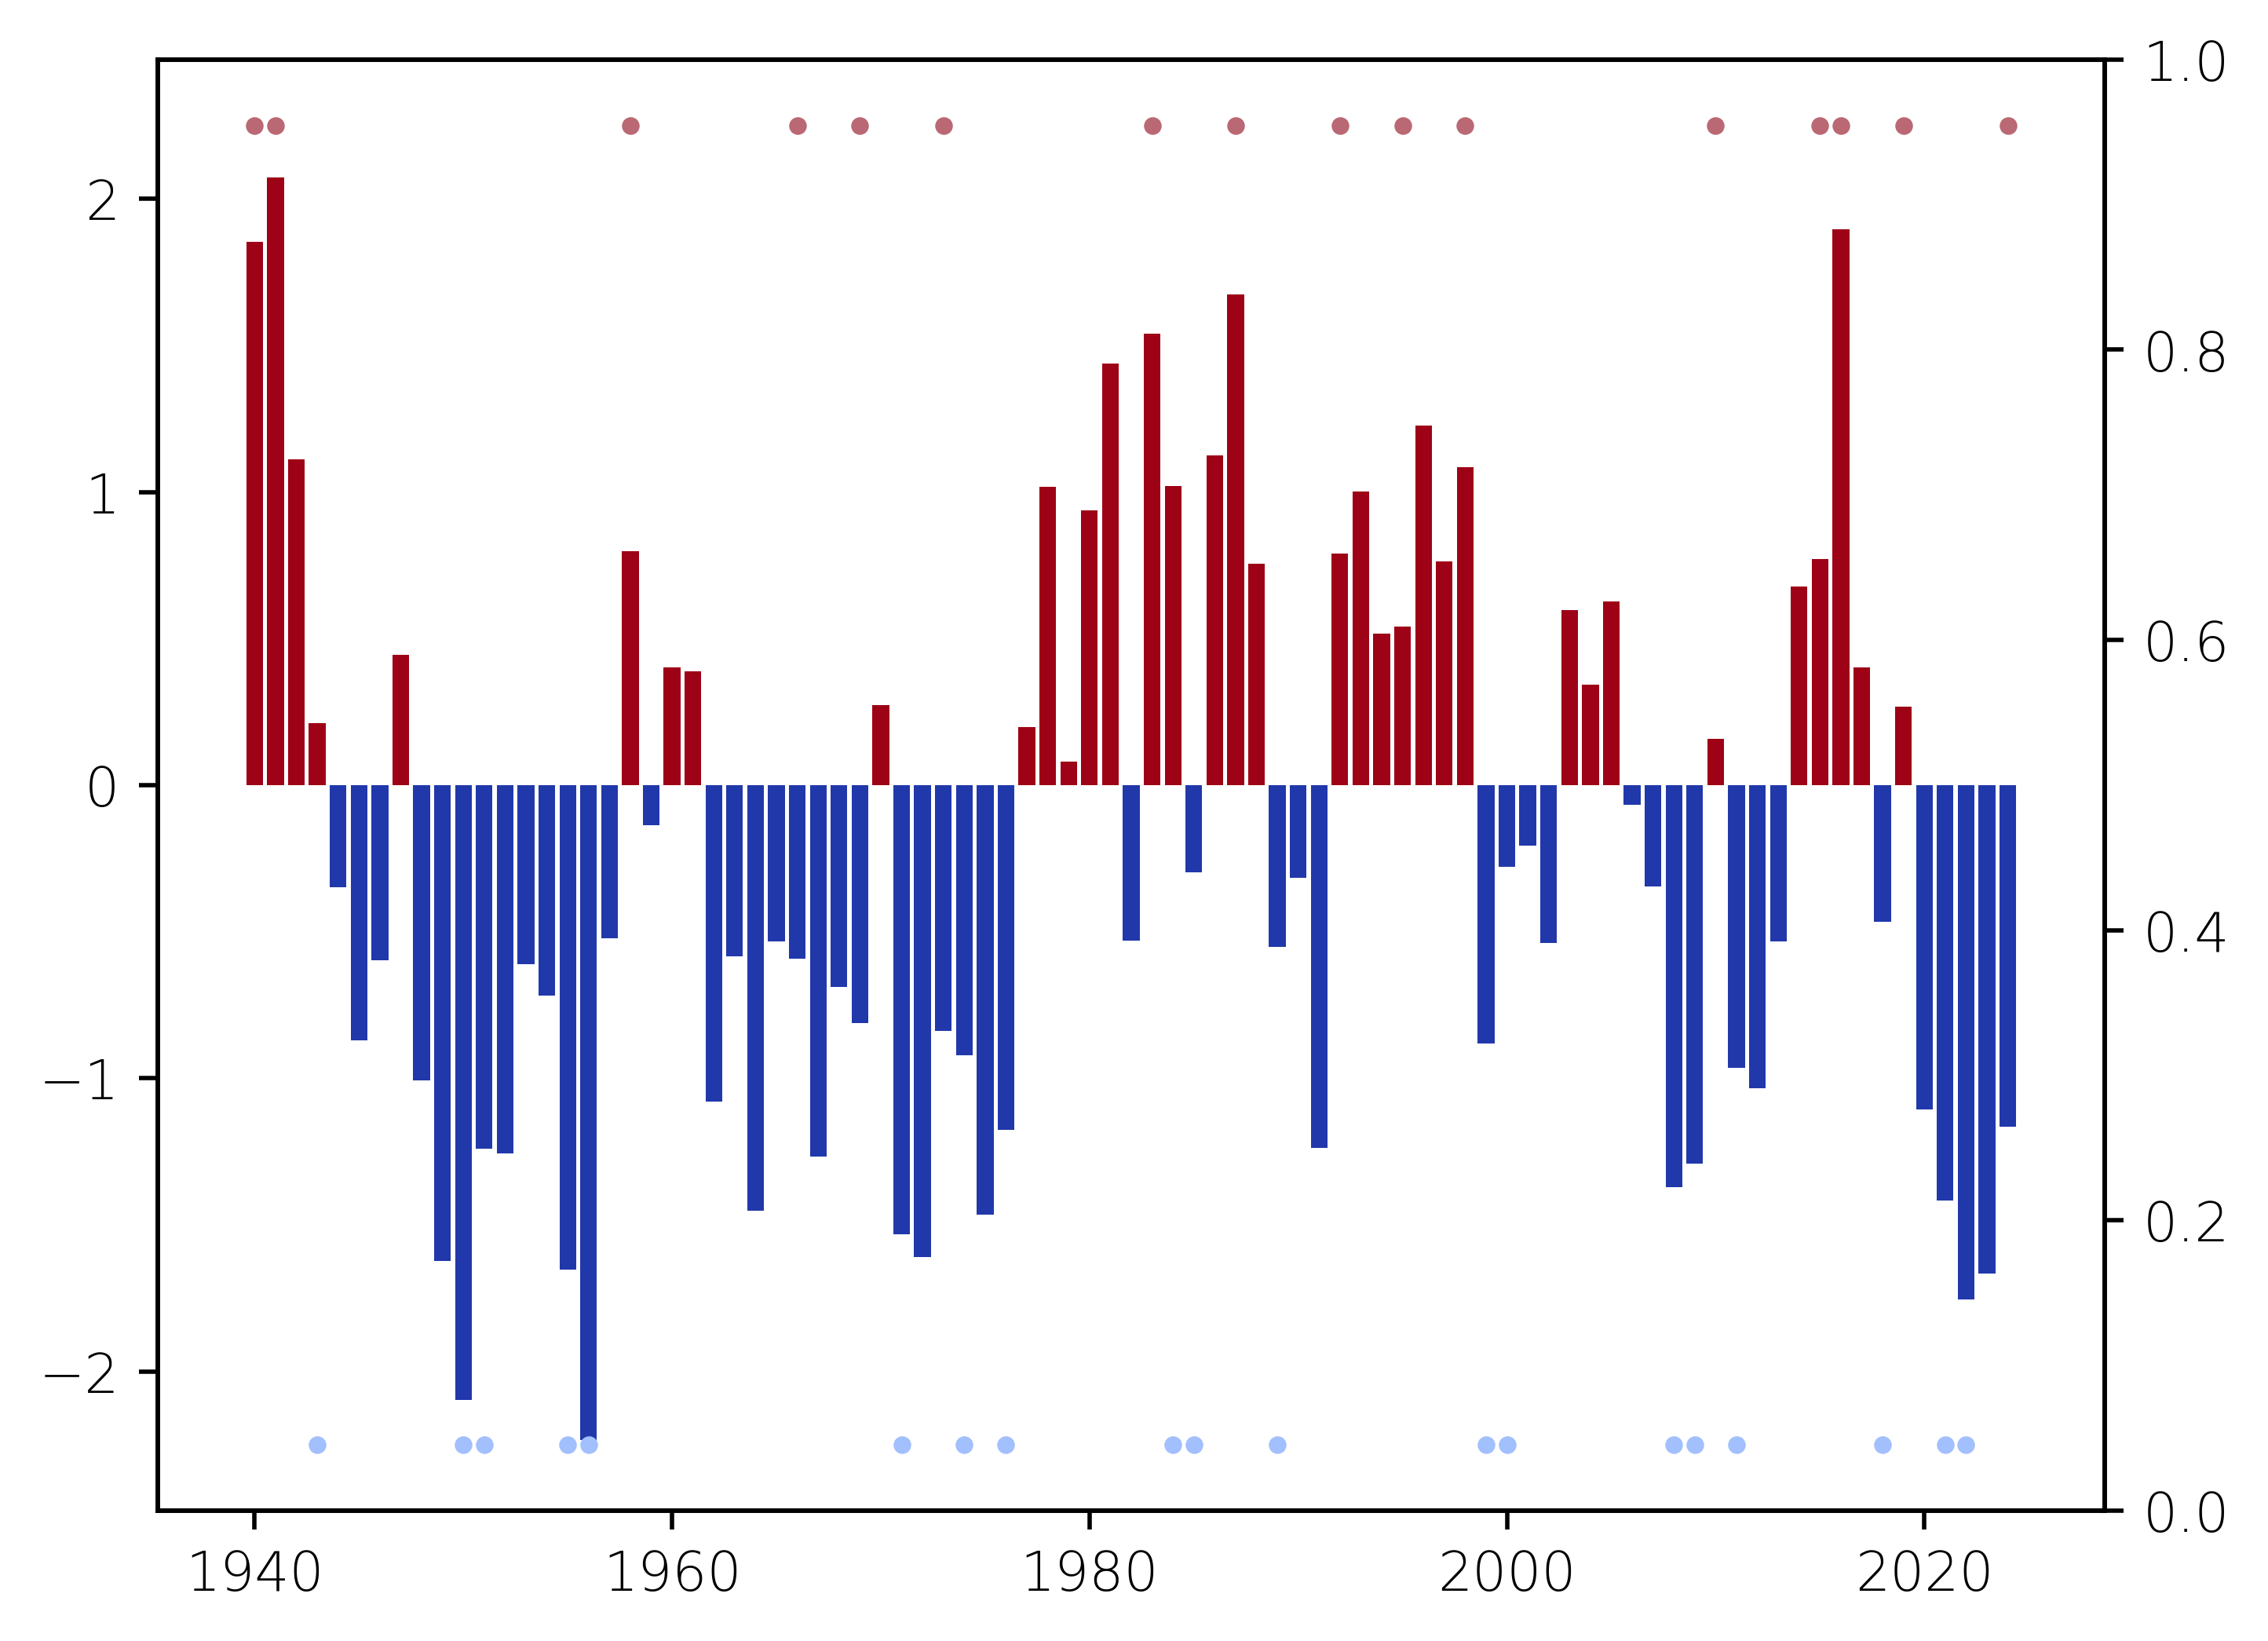

In [25]:
fig, ax = plt.subplots()

years = np.arange(1940, 2025, 1)

ax.bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
ax.bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')

ax2 = ax.twinx()

ax.scatter(years[nino_34_1940_2024_mam_ann == 1], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann ==1]*2.25, color='xkcd:dusky rose', s=5)
ax.scatter(years[nino_34_1940_2024_mam_ann == -1], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann ==-1]*2.25, color='xkcd:pastel blue', s=5)


In [ ]:
    ax[i].bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
    ax[i].bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')